### Imports

In [1]:
from time import time
import matplotlib.pyplot as plt
from functions_watervalues import *

In [2]:
%matplotlib widget

In [3]:
%load_ext line_profiler

### Declarations

In [4]:
dir_study = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase_ref"
name_area = "area"

t1 = ThermalUnit(0.1,100,200,0,42500.0,"1")
t2 = ThermalUnit(0.2,100,100,0,12500.0,"2")
t3 = ThermalUnit(0.3,100,150,1000,7500.0,"3")

reservoir = Reservoir(5e4*200/2,-5.e4,5.e4,200,dir_study,name_area,"reservoir")

area = Area([t1,t2,t3],[reservoir],dir_study,name_area, "area")
area2 = Area([t1,t2],[],dir_study,name_area, "area2")
# area3 = Area([t2],[],dir_study,name_area, "area3")

NTrain = 5
study = Study([area,area2],2.99,0,3,NTrain, {"area":{"area2":(1000,0.001)},"area2":{"area":(1000,0.001)}})

In [9]:
xNsteps = 10
X = np.linspace(0, reservoir.capacity, num = xNsteps)

Ncontrols = 10
U = np.linspace(-reservoir.P_pump * H, -reservoir.P_turb * H, Ncontrols)

### Exact calculation with solver

In [6]:
td = time()
# m,s, x  = SDP_exact(study, area, reservoir, False, X)
V_exact_solver = SDP_exact(study, area, reservoir, False, X)  # Les valeurs de Bellman de la semaine s correspondent aux valeurs pour le début de la semaine s soit la fin de la semaine s-1  
print(time()-td)

258.55867624282837


In [10]:
%lprun -f SDP_exact SDP_exact(study, area, reservoir, False, X)

Timer unit: 1e-07 s

Total time: 261.276 s
File: d:\Users\gerbauxjul\Documents\4-Code\Python\functions_watervalues.py
Function: SDP_exact at line 184

Line #      Hits         Time  Per Hit   % Time  Line Contents
   184                                           def SDP_exact(study: Study, area:Area, reservoir:Reservoir, debut:bool, X):
   185         1        139.0    139.0      0.0      V = np.zeros((len(X), S+1))
   186         1          9.0      9.0      0.0      if debut:
   187                                                   pen = get_penalties(debut,S)
   188                                                   for i in range(len(X)):
   189                                                       V[i,S] = pen(X[i])
   190        53        562.0     10.6      0.0      for s in range(51,-1,-1):
   191        52   44646536.0 858587.2      1.7          model = optModel_exact(study, area, reservoir, s, V, debut, X)
   192       572       7445.0     13.0      0.0          for i in range

In [6]:
# m.solve()
# m.getObjVal()

5972284.7119999975

In [6]:
# vars = m.getVariable()
# sol = m.getSolution()

In [7]:
# solve_and_plot(m, study, s,x)

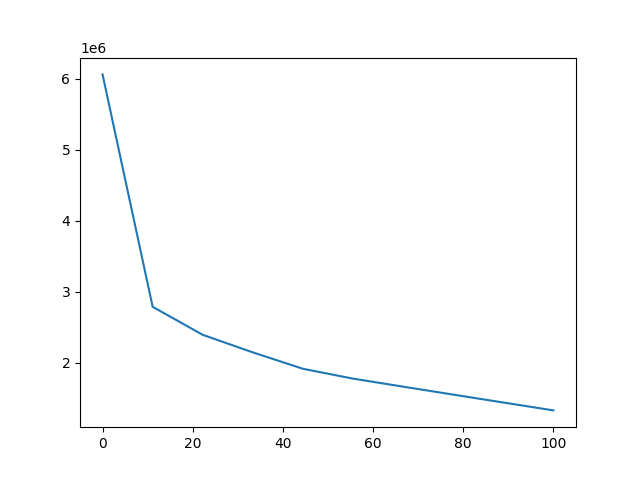

In [7]:
s = 51
plt.figure()
plt.plot(np.linspace(0,100,xNsteps),V_exact_solver[:,s])
plt.show()

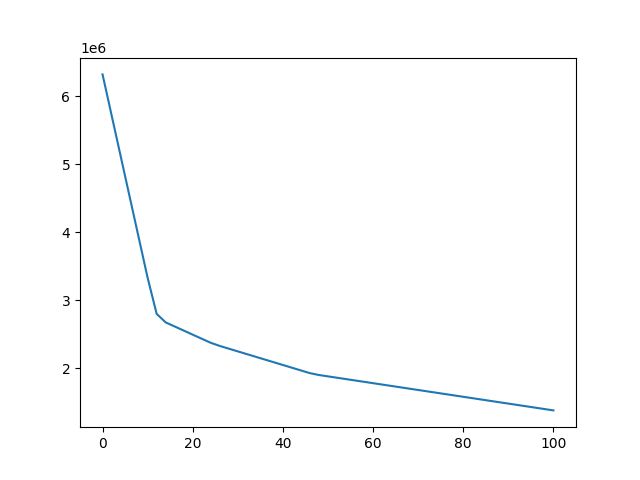

In [16]:
s = 51
plt.figure()
plt.plot(np.linspace(0,100,xNsteps),V_exact_solver[:,s])
plt.show()

### Precalculated rewards

In [10]:
Lu= np.zeros((Ncontrols, S, NTrain))
for u in range(Ncontrols): 
    Lu[u,:,:] =  WeeklyCost(study,area,reservoir,U[u])  

In [11]:
Gu = np.zeros((Ncontrols, S, NTrain))
for u in range(Ncontrols):
    Gu[u, :, :] = Lu[(U>=0).argmax(), :, :] - Lu[u, :, :]

In [12]:
V_tilde = SDP_precalculated_rewards(study,reservoir,False, Gu, X,U)
V_non_tilde = SDP_precalculated_rewards(study, reservoir,True, Gu,X,U)

In [13]:
L_U0 = np.zeros(S+1)

for s in range(S):
    L_U0[s] = np.mean(np.sum(Lu[(U>=0).argmax(), s:52, :], axis=0))

In [17]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = get_penalties(study,reservoir,True,s)
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [18]:
s = 0
i = 1
j = 51
# i = findfirst(STATES.>=Xmin[s-1]);
# j = findlast(STATES.<=Xmax[s-1]);

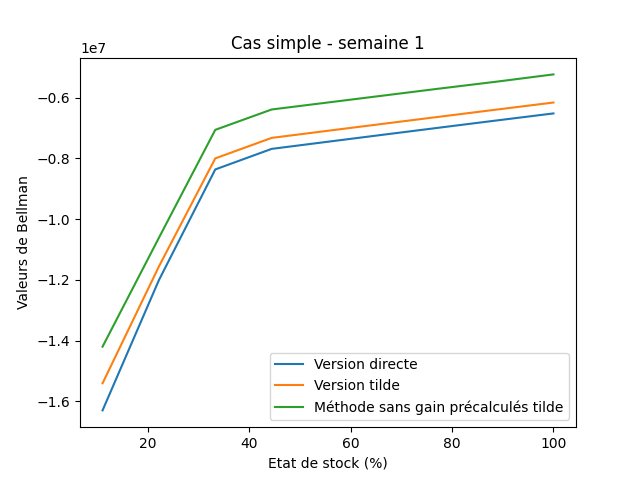

In [19]:
plt.figure()
plt.title(f"Cas simple - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs de Bellman")
plt.plot(X[i:j]/reservoir.capacity*100, V_non_tilde[i:j, s], label="Version directe")
plt.plot(X[i:j]/reservoir.capacity*100, V_tilde[i:j, s]+penalties[i:j,s], label="Version tilde")
plt.plot(X[i:j]/reservoir.capacity*100, L_U0[s] - V_exact_solver[i:j, s]+penalties[i:j,s], label="Méthode sans gain précalculés tilde")
# plt.plot(X[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()

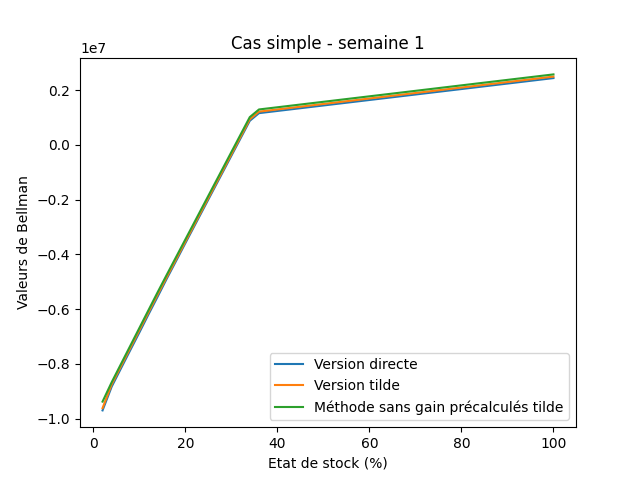

In [21]:
plt.figure()
plt.title(f"Cas simple - semaine {s+1}")
plt.xlabel("Etat de stock (%)")
plt.ylabel("Valeurs de Bellman")
plt.plot(X[i:j]/reservoir.capacity*100, V_non_tilde[i:j, s], label="Version directe")
plt.plot(X[i:j]/reservoir.capacity*100, V_tilde[i:j, s]+penalties[i:j,s], label="Version tilde")
plt.plot(X[i:j]/reservoir.capacity*100, L_U0[s] - V_exact_solver[i:j, s]+penalties[i:j,s], label="Méthode sans gain précalculés tilde")
# plt.plot(X[i:j]/XmaxB*100, penalties[i:j, s], label="Pénalités")
plt.legend()
plt.show()